# Calculation of image quality

Will pull the ImageId from the MongoDB to then grab the associated image from the image server. Then calculate various quality metrics. Finally build a dataframe with the Image ID, and quality scores. Then push back the new info to MongoDB.

`!ssh -f -N -L 27017:irlinv-tellus:27017 irlinv-tellus`

In [1]:
import io, os, sys
import requests
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
from ipywidgets import IntProgress
from IPython.display import display

import skimage as ski
import cv2
import torch
import piq
#import nvidia_smi

sys.path.append('..')

# local library of functions to connect to image server
#import calcimetry.use_server as server
from calcimetry.mongo_api import MongoInfo, MongoAPI
from calcimetry.calcimetry_api import CalcimetryAPI

# parameters where the database is stored, can obviously be distant.
sandbox = False
if os.getcwd() == '/work/home/ai.calcimetry/notebooks':
    print('On the sandbox')
    sandbox = True
    HOST='irlinv-tellus'
    PORT=27017
else:
    # ssh -f -N -L 27017:irlinv-tellus:27017 irlinv-tellus
    HOST='localhost'
    PORT=27017   

In [2]:
#img_path = server.init()
mongo_info = MongoInfo(host=HOST, port=PORT)

In [3]:
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['images'].find()
    df = pd.DataFrame(list(doc))
df

,_id,ImageId,FileName,DrillName,Cote0,Cote1,PxSize,PySize,px0,px1,k_Up,k_Down,k_Arrow,criteria
0,632336418f6c6e412bdc4a9b,0,GTR2012-07_0023_BPE4023_0000_0110.jpg,BPE4023,0,110,3231,625,28.0,3137.0,"[[55, 173], [259, 179], [430, 177], [583, 171]...","[[66, 325], [240, 328], [572, 326], [727, 335]...","[[1505, 272], [1530, 273], [1767, 279], [2090,...","{'n_measurements': 6, 'resolution': 0.03538115..."
1,632336418f6c6e412bdc4a9c,1,GTR2012-07_0023_BPE4023_0090_0200.jpg,BPE4023,90,200,3456,630,172.0,3311.0,"[[11, 187], [556, 189], [1081, 190], [1590, 18...","[[8, 344], [591, 346], [1157, 348], [1505, 349...","[[10, 268], [1373, 268], [1693, 271], [1980, 2...","{'n_measurements': 8, 'resolution': 0.03504300..."
2,632336418f6c6e412bdc4a9d,2,GTR2012-07_0023_BPE4023_0180_0290.jpg,BPE4023,180,290,3456,630,135.0,3273.0,"[[8, 166], [388, 171], [1155, 177], [2061, 184...","[[14, 329], [440, 338], [920, 336], [1295, 344...","[[3, 245], [208, 248], [372, 266], [1644, 265]...","{'n_measurements': 4, 'resolution': 0.03505417..."
3,632336418f6c6e412bdc4a9e,3,GTR2012-07_0023_BPE4023_0270_0380.jpg,BPE4023,270,380,3456,636,97.0,3224.0,"[[5, 181], [811, 182], [1253, 190], [2597, 199...","[[5, 343], [632, 343], [928, 342], [1212, 356]...","[[6, 260], [820, 257], [1253, 275], [1939, 272...","{'n_measurements': 4, 'resolution': 0.03517748..."
4,632336418f6c6e412bdc4a9f,4,GTR2012-07_0023_BPE4023_0350_0440.jpg,BPE4023,350,440,2824,640,2.0,2574.0,"[[6, 185], [186, 187], [524, 180], [1345, 184]...","[[6, 346], [296, 346], [546, 340], [1268, 348]...","[[5, 259], [519, 257], [1199, 260], [1580, 254...","{'n_measurements': 2, 'resolution': 0.03499222..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,63283cf9f27bc4104e69bf0d,2340,GTR2005-06_0029_SUG1101_1783_1883.jpg,SUG1101,1783,1880,2048,444,4.0,2004.0,"[[78, 61], [678, 62], [1043, 71], [2039, 100]]","[[106, 227], [914, 238], [1423, 250], [2039, 2...","[[56, 134], [297, 124], [412, 138], [604, 139]...","{'n_measurements': 1, 'resolution': 0.0485, 'y..."
3064,63283cf9f27bc4104e69bf0e,2341,GTR2005-06_0029_SUG1101_1805_1899.jpg,SUG1101,1805,1898,2048,492,89.0,1967.0,"[[74, 77], [1122, 88], [2035, 123]]","[[76, 248], [1321, 266], [2017, 289]]","[[52, 153], [615, 153], [1110, 163], [1441, 17...","{'n_measurements': 0, 'resolution': 0.04952076..."
3065,63283cf9f27bc4104e69bf0f,2342,GTR2005-06_0029_SUG1101_1900_1995.jpg,SUG1101,1900,1994,1959,432,22.0,1954.0,"[[13, 63], [429, 75], [760, 87], [1948, 76]]","[[37, 236], [738, 252], [1339, 253], [1941, 24...","[[92, 171], [565, 180], [1117, 185], [1861, 177]]","{'n_measurements': 1, 'resolution': 0.04865424..."
3066,63283cf9f27bc4104e69bf10,2343,GTR2005-06_0029_SUG1101_1985_2085.jpg,SUG1101,1985,2083,2048,468,14.0,2024.0,"[[46, 59], [631, 85], [974, 100], [2039, 111]]","[[39, 227], [476, 251], [656, 258], [1275, 278...","[[613, 183], [825, 191], [1385, 204], [2028, 2...","{'n_measurements': 1, 'resolution': 0.04875621..."


### The variance of the Laplacian can be a measure of the sharpness of the image, or the focus

In [4]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

### Magnitude of the gradient to get sharpness of edges

In [5]:
def gradient_magnitude(image):
    #Get magnitude of gradient for given image
    ddepth = cv2.CV_64F
    dx = cv2.Sobel(image, ddepth, 1, 0)
    dy = cv2.Sobel(image, ddepth, 0, 1)
    mag = cv2.magnitude(dx, dy)
    return mag

## Colour analysis
https://towardsdatascience.com/building-an-image-color-analyzer-using-python-12de6b0acf74

* First, we are using k-Means to cluster the top colors. Inside the function we are passing the value of how many clusters do we want to divide. Here is the documentation for K-Means clustering. After clustering we predict the colors that weigh the most — meaning getting the most area on the image.
* Secondly, we are calling the Counter function. Counter creates a container to the elements as dictionary keys, and their volume is store as dictionary values. If you are not familiar with dictionaries, they store data in key: value pairs. They are like function, and when you pass in the “key,” you can “value” as a return. Then we are ordering the colors according to the keys.

In [6]:
def prep_image(raw_img):
    modified_img = cv2.resize(raw_img, (900, 600), interpolation = cv2.INTER_AREA)
    modified_img = modified_img.reshape(modified_img.shape[0]*modified_img.shape[1], 3)
    return modified_img

def color_analysis(img):
    clf = KMeans(n_clusters = 5)  # 5 top colours
    color_labels = clf.fit_predict(img)
    center_colors = clf.cluster_centers_
    counts = Counter(color_labels)
    ordered_colors = [center_colors[i] for i in counts.keys()]
    return ordered_colors

### From the dataframe caclulate some metrics

Add some Facebook metrics too: `piq` PyTorch Image Quality
* https://github.com/photosynthesis-team/piq/blob/master/examples/image_metrics.py

In [7]:
Resolution = []
Focus = []
GradientMax = []
GradientSTD = []
Colour1 = []
Colour2 = []
Colour3 = []
Colour4 = []
Colour5 = []
BRISQUE_i = []

missing_images = []

f = IntProgress(min=0, max=len(df)) # instantiate the bar
display(f) # display the bar

for ImageId in df['ImageId']:
    
    with CalcimetryAPI(mongo_info=mongo_info) as calcimetry_api:
        img = calcimetry_api.read_image(ImageId)
        
        if img is not None:

            # focus metric
            gray = cv2.cvtColor(np.asarray(img.jpg), cv2.COLOR_BGR2GRAY)
            Focus.append(variance_of_laplacian(gray))

            # Gradient metric
            GradientMax.append(np.max(gradient_magnitude(gray)[:]))
            GradientSTD.append(np.std(gradient_magnitude(gray)[:]))

            # Top five colours
            try:
                colours = color_analysis(prep_image(np.asarray(small)))
                Colour1.append(colours[0])
                Colour2.append(colours[1])
                Colour3.append(colours[2])
                Colour4.append(colours[3])
                Colour5.append(colours[4])
            except:
                Colour1.append(np.nan)
                Colour2.append(np.nan)
                Colour3.append(np.nan)
                Colour4.append(np.nan)
                Colour5.append(np.nan)

            if sandbox == True:
            # pytorch image quality, use try, except loop to keep going if image is too large or does not conform
                try:
                    x = torch.tensor(np.asarray(img.jpg)).permute(2, 0, 1)[None, ...] / 255.
                    if torch.cuda.is_available():
                        # Move to GPU to make computaions faster
                        # print(torch.cuda.is_available())
                        x = x.cuda()
                    brisque_index: torch.Tensor = piq.brisque(x, data_range=1., reduction='none')

                    BRISQUE_i.append(brisque_index.item())
                except Exception as e:
                    print(f'Error in PyTorch with image {ImageId}\n')
                    print(e)
                    BRISQUE_i.append(np.nan)

                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                del x

        else:  # not an image
            print(f'{fileName} is not a jpg')
            missing_images.append(fileName)
            Focus.append(np.nan)
            GradientMax.append(np.nan)
            GradientSTD.append(np.nan)
            Colour1.append(np.nan)
            Colour2.append(np.nan)
            Colour3.append(np.nan)
            Colour4.append(np.nan)
            Colour5.append(np.nan)
            BRISQUE_i.append(np.nan)
            
        f.value += 1

IntProgress(value=0, max=3068)

In [8]:
# resolution
dpxdx = (df['px1'] - df['px0']) / (df['Cote1'] - df['Cote0'])

TypeError: Image data of dtype object cannot be converted to float

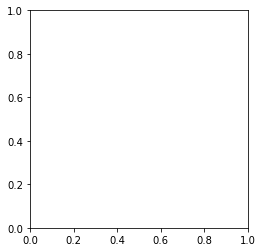

In [9]:
plt.imshow(img)
plt.show()

In [10]:
df.to_pickle('./local_quality_score_data.pkl')